<a href="https://colab.research.google.com/github/yinghao1019/NLP_and_DL_practice/blob/master/Conv_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchtext.datasets import WMT14,Multi30k
from torchtext.data import Field,BucketIterator,metrics
import numpy as np
import matplotlib.pyplot
import spacy

import os
import tqdm
import random
import math
import time

##文字預處理與載入資料
在載入資料集部分，我們採用torchtext library內建的Machine translation資料集Multi30k 進行練習，在翻譯語言的部分，則是選擇了German-English。

---
在文字預處理方面，這邊採用spacy的tokenizer模型進行word segment。隨後將其token轉成小寫,在過濾noise部分,則是過濾掉了在train corpus中詞頻低於2的詞彙並建立vocabulary。並在每個sentences的前後加入\<sos>,\<eos>的token。

In [ ]:
#set random seed to fixed random number
Random_SEED=1234
random.seed(Random_SEED)
np.random.seed(Random_SEED)
torch.random.manual_seed(Random_SEED)
torch.cuda.manual_seed_all(Random_SEED)
if torch.backends.cudnn.is_available():
  torch.backends.cudnn.deterministic=True
#set gpu device
device=torch.device('cuda:0')
spacy.require_gpu()

In [ ]:
#load tokenizer Model
de_tokenizer=spacy.load('de_core_news_sm')
# fr_tokenizer=spacy.load('fr_core_news_sm')
en_tokenizer=spacy.load('en_core_web_sm')

#build tokenize process
#English toknize process
def en_tokenize(text):
  return [token.text.lower() for token in en_tokenizer.tokenizer(text)]
#Gereman toknize process
def de_tokenize(text):
  return [token.text.lower() for token in de_tokenizer.tokenizer(text)]
#Franch toknize process
def fr_tokenize(text):
  return [token.text.lower() for token in fr_tokenizer.tokenizer(text)]

#build Field,we will translate English-German & English-Franch
TRG_en=Field(init_token='<sos>',eos_token='<eos>',batch_first=True,tokenize=en_tokenize)
SRC_de=Field(init_token='<sos>',eos_token='<eos>',batch_first=True,tokenize=de_tokenize)
# TRG_fr=Field(init_token='<sos>',eos_token='<eos>',tokenize=fr_tokenize)

#build data
train_data,val_data,test_data=Multi30k.splits(exts=('.de','.en'),fields=(SRC_de,TRG_en))
print(f'Dataset size:{len(train_data)}\n{len(val_data)}\n{len(test_data)}\n')

#display data examples info.
train_idx=random.choice(range(0,len(train_data)))
train_src=train_data.examples[train_idx].src
train_trg=train_data.examples[train_idx].trg
print(f'train src_sents:{train_src}\n train trg sents:{train_trg}')
#Build vocabulary
SRC_de.build_vocab(train_data,min_freq=2,specials=['<unk>','<pad>'])
TRG_en.build_vocab(train_data,min_freq=2,specials=['<unk>','<pad>'])


In [ ]:
#build Data iterator with bs128
Batch_size=128
train_iter,val_iter,test_iter=BucketIterator.splits((train_data,val_data,test_data),batch_sizes=(Batch_size,Batch_size,Batch_size),device=device)

##Encoder implementation
![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq1.png)
圖片來源:https://github.com/bentrevett/pytorch-seq2seq  

Encoder每層Layer的說明-  
1.token and position Embed:首先，我們會將input sentence的word idx轉換成word Embedding，除此之外，為了加強每個tokeng位置順序的資訊，採用element-wise sum的方法將pos embed加入至word Embed.  

2.linear layer:將embed_vector轉換成hid_vector.  

3.N個convolution block:然後我們將轉後的hid_vector餵至'conv block'後，藉由N個'conv block'會提取出word的重要資訊。  

4.linear_layer:將hid_vector進行linear transform變成conved output。其中shape為=[Bs,seqlen,embed_dim]  

5.residul connection:將Embedding vector與conved output進行加總成為combined output此目的為加強conved output的source word資訊。  

####而Convolution block中演算流程如下圖:
![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq2.png)  
圖片來源:https://github.com/bentrevett/pytorch-seq2seq

假設當前是採用n個filter以及1個block的情況下來說明運算流程:  
1.在Input 部分:採用前述合併postion與word Embedding的combine vector的combine vector  

2.convolution layer:我們將使用n個filter來extract feature_map，並且讓它只能在seqLen那個方向上的dim進行移動，這樣的想法可以把它看作如同採用N-gram Model來捕捉詞彙之間的關聯。  

```bash
Note:由於希望通過filter後的input ,output seqLen一致，所以採用padding的方式來進行調整。由於設定GLU作為activation func.如果為了讓input vector與output vector的dim一致，須將filter的數量設成hidden_dim的2倍才能達成條件。
```  

3.最後我們將output與Input在進行一次residual connection.  
 
4.第二個block的input則是吃第一個block的output，後續的block也是這樣。   


In [ ]:
#build convolution block
class cnnEncoder(nn.Module):
  def __init__(self,input_dim,embed_dim,hid_dim,kernel_size,n_layers,max_length,drop_rate,device):
    super(cnnEncoder,self).__init__()
    #embed_layer attr
    self.input_dim=input_dim
    self.pos_dim=max_length
    self.embed_dim=embed_dim
    #conv block attr.
    self.n_layers=n_layers
    self.n_channels=hid_dim*2
    self.hid_dim=hid_dim
    self.kernel_size=kernel_size
    self.padding=(self.kernel_size-1)//2
    
    #build layer
    self.word_embed=nn.Embedding(input_dim,embed_dim)
    self.pos_embed=nn.Embedding(max_length,embed_dim)
    self.embed2hid=nn.Linear(embed_dim,hid_dim)
    self.conv_blocks=nn.ModuleList([nn.Conv1d(self.hid_dim,
                        self.n_channels,
                        kernel_size=self.kernel_size,
                        padding=self.padding)
                    for _ in range(self.n_layers)])
    self.hid2embed=nn.Linear(hid_dim,embed_dim)
    self.device=device
    self.dropout=nn.Dropout(drop_rate)
    self.scale=torch.sqrt(torch.FloatTensor([0.5])).to(device)
  def forward(self,src_tensors):
    #create pos tensors
    batch_size=src_tensors.size()[0]
    src_len=src_tensors.size()[1]
    pos_tensors=torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device)

    #get pos and word token Embed
    #src_tokenEmbeds=[Bs,seqlen,embed_dim],src_posEmbeds=[Bs,seqlen,embed_dim]
    src_tokenEmbeds=self.word_embed(src_tensors)
    src_posEmbeds=self.pos_embed(pos_tensors)

    #elemwise sum and linear transform
    #src_hids=[Bs,seqlen,hid_dim]
    src_embeds=self.dropout(src_tokenEmbeds+src_posEmbeds)
    src_hids=self.embed2hid(src_embeds)

    #permute dim
    #conv_inputs=[Bs,hid,seqlen]
    conv_inputs=src_hids.permute(0,2,1)

    #N convblock extract conved embed
    for convb in self.conv_blocks:
      #Fed into convolution filter
      #conved_output=[Bs,2*hid_dim,seqlen]
      conved_output=convb(self.dropout(conv_inputs))

      #through glu activation,shape=[Bs,2*hid_dim,seqlen]
      #Residual connection=[Bs,hid_dim,seqlen]
      conved_output=(conv_inputs+F.glu(conved_output,dim=1))*self.scale
      conv_inputs=conved_output

    #tranform conved output hid_dim to Embed_dim
    #conved_output=[Bs,seqLen,Embed_dim]
    conved_output=self.hid2embed(conved_output.permute(0,2,1))

    #Through Residual connect
    #combined_output=[Bs,seqLen,Embed_dim]
    combined_output=(conved_output+src_embeds)*self.scale
    return conved_output,combined_output

###Decoder 架構部分  

![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq3.png)
圖片來源:https://reurl.cc/Gdx0Qp  

&nbsp;&nbsp;&nbsp;在Decoder架構部分與encoder極為相似，僅在conv block已及最後一層不採用Residual connect的方式。且特別的地方在於相較於Rnn-based Decoder,他的input token可採用平行化輸入的方式，而不是像rnn-based 的方法採用序列化的方式進行。  

&nbsp;&nbsp;&nbsp;而在其conv block的輸入部分，除了原有的hid vector,還輸入conved output,combined output(attention用),已及embedding vector(Residual connection用)。

###Decoder的conv block部分
![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq4.png)  
圖片來源:https://reurl.cc/Gdx0Qp

&nbsp;&nbsp;&nbsp;在conv block部分中也是與encoder的相似，特別的是我們只採用單邊的padding策略來維持filter output後的seqlen。除此之外，我們也採用attention的方法來增強context information。  

&nbsp;&nbsp;&nbsp;在attention部分，我們採用類似標準attention的方法進行,query=當前feature map的output+Embedding vector,key=conved_output,value=combined output,在計算完每個token的attnetion Repr.後，我們將輸入至attn layer前的feature map進行residual connection,隨後在與輸入至block的hid_vector進行Residual connection來完成一個conv block的運算。  

**\#在attention機制時，key採用conved_output的理由為相較於combined output,他涵蓋了大量的context 資訊，而combined則是含有source token的資訊。**

In [ ]:
class cnnDecoder(nn.Module):
  def __init__(self,output_dim,embed_dim,hid_dim,kernel_size,n_layers,max_length,drop_rate,trg_pad_idx,device):
    super(cnnDecoder,self).__init__()
    #set decoder attr
    self.output_dim=output_dim
    self.pos_dim=max_length
    self.embed_dim=embed_dim
    self.device=device
    self.trg_pad_idx=trg_pad_idx
    #set conv_block attr.
    self.hid_dim=hid_dim
    self.n_filters=hid_dim*2
    self.kernel_size=kernel_size
    self.n_layers=n_layers
    self.padding=kernel_size-1

    #build layer
    self.word_embed=nn.Embedding(output_dim,embed_dim)
    self.pos_embed=nn.Embedding(self.pos_dim,embed_dim)
    self.embed2hid=nn.Linear(self.embed_dim,self.hid_dim)
    self.hid2embed=nn.Linear(self.hid_dim,self.embed_dim)
    self.attn_hid2embed=nn.Linear(self.hid_dim,self.embed_dim)
    self.attn_embed2hid=nn.Linear(self.embed_dim,self.hid_dim)
    self.conv_blocks=nn.ModuleList([nn.Conv1d(self.hid_dim,self.n_filters,kernel_size=self.kernel_size) for _ in range(self.n_layers)])
    self.padding=kernel_size-1
    self.dropout=nn.Dropout(drop_rate)
    self.output_layer=nn.Linear(self.embed_dim,self.output_dim)
    self.scale=torch.sqrt(torch.FloatTensor([0.5])).to(device)
  def calculate_attn(self,hid_tensors,embed_tensors,encoder_conved,encoder_combined):
    #hid_tensors=[Bs,hid_dim,trg_seqlen]
    #embed_tensors=[Bs,trg_seqlen,embed_dim]
    #encoder_conved=[Bs,src_seqlen,embed_dim]
    #encoder_combined=[Bs,src_seqlen,embed_dim]

    #residual connection
    #attn_query=[Bs,trg_seqlen,embed_dim]
    attn_query=(self.attn_hid2embed(hid_tensors.permute(0,2,1))+embed_tensors)*self.scale

    #get attn weight
    #attn_w=[Bs,trg_seqlen,src_seqlen]
    attn_w=torch.matmul(attn_query,encoder_conved.permute(0,2,1))

    #through softmax and weighted sum encoder_combined
    #attn_tensors=[Bs,trg_seqlen,emed_dim]
    attn_tensors=torch.matmul(F.softmax(attn_w,dim=2),encoder_combined)

    #convert to hid_dim and permute
    #attn_tensors=[Bs,hid_dim,seqlen]
    attn_tensors=self.attn_embed2hid(attn_tensors).permute(0,2,1)

    #apply residual connection with input_hid and attended_input
    attn_tensors=(attn_tensors+hid_tensors)*self.scale
    return attn_tensors,F.softmax(attn_w,dim=2)
  def forward(self,trg_tensors,encoder_conved,encoder_combined):
    #create pos embedding
    bs=trg_tensors.size()[0]
    seqlen=trg_tensors.size()[1]
    pos_tensors=torch.arange(0,seqlen).repeat(bs,1).to(self.device)

    #pos_embed=[bs,seqlen,Embed_dim],token_embed=[bs,seqlen,Embed_dim]
    token_embed=self.word_embed(trg_tensors)
    pos_embed=self.pos_embed(pos_tensors)

    #element-wise sum,embed_tensors=[Bs,seqLen,embed_dim]
    embed_tensors=self.dropout(token_embed+pos_embed)
    #convert into hid dim and transpose,conv_input=[Bs,hid_dim,seqLen]
    conv_inputs=self.embed2hid(embed_tensors).permute(0,2,1)
    
    for conv_b in self.conv_blocks:
      #create conv pad to avoid cheat
      #new conv_inputs=[Bs,hid_dim,(filter_size-1)+orig_seqlen]
      conv_inputs=self.dropout(conv_inputs)
      conv_pad=torch.zeros(bs,self.hid_dim,self.padding).fill_(self.trg_pad_idx).to(self.device)
      conv_pad=torch.cat((conv_pad,conv_inputs),dim=2)

      #conv_output=[Bs,hid_dim*2,seqLen]
      conv_outputs=conv_b(conv_pad)
      #through GLU and transpose=[Bs,seqlen,hid_dim]
      conv_outputs=F.glu(conv_outputs,dim=1)
      #calculate attention=[Bs,hid_dim,seqlen]
      conv_outputs,conv_attnW=self.calculate_attn(conv_outputs,embed_tensors,encoder_conved,encoder_combined)

      #Residual connection attn output & conv_inputs
      #conv_outputs=[Bs,hid_dim,seqLen]
      conv_outputs=(conv_outputs+conv_inputs)*self.scale
      conv_inputs=conv_outputs

    #transform hid_dim to embed_dim=[Bs,seqlen,embed_dim]
    embed_outputs=self.hid2embed(conv_outputs.permute(0,2,1))

    #output each token logitics=[Bs,seqlen,output_dim]
    #conv_attnW=[Bs,]
    return self.output_layer(embed_outputs),conv_attnW

####建立seq2seq class來連接encoder,decoder的資訊流
在forward pass時，先藉由Encoder將source sentence編碼成conved_output,combined_output。再將target tensor已及conved_output,combined_output進行解碼完成翻譯


In [ ]:
class cnn_Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder):
    super(cnn_Seq2Seq,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
  def forward(self,src_tensors,trg_tensors):
    #src_tensors=[Bs,src_seqlen]
    #trg_tensors=[Bs,trg_seqlen-1]

    #encoding src_tensor
    #conved_output=[Bs,seqlen,Embed_dim],conv_combined=[Bs,seqlen,Embed_dim]
    conved_output,conv_combined=self.encoder(src_tensors)
    #decoder conved_output
    output_logitics,attn_w=self.decoder(trg_tensors,conved_output,conv_combined)
    return output_logitics,attn_w

設置建構模型參數

In [ ]:
#set Encoder & Decoder hyperparameters
Input_dim=len(SRC_de.vocab)
Output_dim=len(TRG_en.vocab)
Embed_dim=256
hid_dim=512 #so filter size=1024
Encoder_layers=10
Decoder_layers=10
Enc_kernel_size=3
Dec_kernel_size=3
Max_length=100
Enc_dropout=0.25
Dec_dropout=0.25
TRG_pad_idx=TRG_en.vocab.stoi['<pad>']
model_params={'encoder':{'input_dim':Input_dim,'kernel_size':Enc_kernel_size,'n_layers':Encoder_layers,'drop_rate':Enc_dropout},
       'decoder':{'output_dim':Output_dim,'kernel_size':Dec_kernel_size,'n_layers':Decoder_layers,'drop_rate':Dec_dropout,'trg_pad_idx':TRG_pad_idx},
       'common':{'embed_dim':Embed_dim,'hid_dim':hid_dim,'max_length':Max_length,'device':device}}
model_dir='./model'
model_path='s2s_model.pt'

In [ ]:
def count_parameters(m):
  return sum([p.numel() for p in m.parameters() if p.requires_grad])

建立Model

In [ ]:
encoder_model=cnnEncoder(**model_params['encoder'],**model_params['common'])
decoder_model=cnnDecoder(**model_params['decoder'],**model_params['common'])
s2s_model=cnn_Seq2Seq(encoder_model,decoder_model).to(device)#put model to GPU
#compute Model trainable parameters
print(f'Model trainable params num:{count_parameters(s2s_model)}')
print(f'Model artictcure:{s2s_model}')

#define loss func and apadtive learning strategy
optimizer=optim.Adam(s2s_model.parameters(),lr=1e-3)
criterion=nn.CrossEntropyLoss(ignore_index=TRG_pad_idx)
#define lr decay for stable training Model
lr_scheduler=optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.75)

Model trainable params num:37351685
Model artictcure:cnn_Seq2Seq(
  (encoder): cnnEncoder(
    (word_embed): Embedding(7855, 256)
    (pos_embed): Embedding(100, 256)
    (embed2hid): Linear(in_features=256, out_features=512, bias=True)
    (conv_blocks): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), paddin

定義train,evaluate Model的pipeline 已及能儲存和載入model資訊的func(與前幾個practice差不多)

In [ ]:
#define model training pipeline
def train_model(model,train_iter,criterion,optimizer,device,clip):
  train_loss=0
  model.train()
  for bs in train_iter:
    if next(model.parameters()).is_cuda:
      src_tensors=bs.src.to(device)
      trg_tensors=bs.trg.to(device)
    else:
      src_tensors=bs.src
      trg_tensors=bs.trg
    output_trg,_=model(src_tensors,trg_tensors[:,:-1])
    #compute loss
    output_trg=output_trg.reshape(-1,model.decoder.output_dim)
    labels_trg=trg_tensors[:,1:].reshape(-1)
    loss=criterion(output_trg,labels_trg)
    train_loss+=loss.item()

    #compute gradient & clipping
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(),clip)

    #update model weight
    optimizer.step()
    optimizer.zero_grad()
  return train_loss/len(train_iter)
#define model testing pipeline
def evaluate_model(model,val_iter,criterion,device):
  total_loss=0
  model.eval()
  with torch.no_grad():
    for bs in val_iter:
      if next(model.parameters()).is_cuda:
        src_tensors=bs.src.to(device)
        trg_tensors=bs.trg.to(device)
      else:
        src_tensors=bs.src
        trg_tensors=bs.trg
      trg_outputs,_=model(src_tensors,trg_tensors[:,:-1])
      #compute loss
      trg_outputs=trg_outputs.reshape(-1,model.decoder.output_dim)
      trg_labels=trg_tensors[:,1:].reshape(-1)
      loss=criterion(trg_outputs,trg_labels)
      total_loss+=loss.item()
  return total_loss/len(val_iter)
def save_modelCkp(model,optimizer,lr_scheduler,model_params,epochs,model_dir,model_path):
  if not os.path.exists(model_dir):
    print('Model dir not exists')
    os.mkdir(model_dir)
    print(f'Already create directory:{model_dir}!')
  save_path=os.path.join(model_dir,model_path)
  torch.save({
        'model':model.state_dict(),'optimzier':optimizer.state_dict(),
        'model_params':model_params,'scheduler':lr_scheduler.state_dict(),
        },save_path)
  print(f'Model checkpoint already saved to{save_path}!')
def load_modelCkp(model_dir,model_path):
  save_path=os.path.join(model_dir,model_path)
  #detect dir_path
  if os.path.exits(model_dir):
    print('Model dir exists...')
  else:
    raise FileNotFoundError('Model dir not exists')

  try:
    ck_point=torch.load(save_path)
    print('Successful load Model info.')
    return ck_point
  except FileNotFoundError:
    print("Save path don't exists")

**開始訓練模型**，定義訓練epochs=15、Gradient normalization=1,並且採用expoential lr_decay的策略。  

除此之外，每隔3個epochs以及最後一個epochs就儲存一次model,optimizer,lr_scheduler資訊。

In [ ]:
train_epochs=15
grad_clip=0.1
epochs_progress=tqdm.trange(train_epochs)
save_everyEpochs=3
for ep in epochs_progress:
  
  start_time=time.time()
  #train Model
  train_loss=train_model(s2s_model,train_iter,criterion,optimizer,device,grad_clip)
  #update learning rate
  ep_lr=lr_scheduler.get_last_lr()
  lr_scheduler.step()

  end_time=time.time()
  #evaluate Model
  epochs_loss=evaluate_model(s2s_model,val_iter,criterion,device)#compute val loss

  #save Model checkpoints in every 3 epochs and final epochs
  if (ep+1)%save_everyEpochs==0 or (ep+1)%save_everyEpochs==train_epochs:
    save_modelCkp(s2s_model,optimizer,lr_scheduler,model_params,ep+1,model_dir,model_path)
  
  #display Training information
  print(f'[{ep+1}/{train_epochs}] train_loss:{train_loss} \t eval_loss:{epochs_loss}\n \
      epoch_lr:{ep_lr} \t cost_time:{end_time-start_time}s')







  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)






  7%|▋         | 1/15 [01:07<15:48, 67.73s/it]

[1/15] train_loss:5.593705547013472 	 eval_loss:3.853549540042877
       epoch_lr:[0.001] 	 cost_time:67.21696281433105s








 13%|█▎        | 2/15 [02:14<14:38, 67.57s/it]

[2/15] train_loss:3.571120933289045 	 eval_loss:2.8873246014118195
       epoch_lr:[0.00075] 	 cost_time:66.66766166687012s








 20%|██        | 3/15 [03:23<13:34, 67.86s/it]

Model checkpoint already saved to./model/s2s_model.pt!
[3/15] train_loss:2.8928486901758 	 eval_loss:2.4225368201732635
       epoch_lr:[0.0005625000000000001] 	 cost_time:66.5062894821167s








 27%|██▋       | 4/15 [04:30<12:25, 67.74s/it]

[4/15] train_loss:2.509196697352741 	 eval_loss:2.182445466518402
       epoch_lr:[0.00042187500000000005] 	 cost_time:66.93798327445984s








 33%|███▎      | 5/15 [05:38<11:15, 67.54s/it]

[5/15] train_loss:2.282179272647471 	 eval_loss:2.0797792226076126
       epoch_lr:[0.00031640625000000006] 	 cost_time:66.53240442276001s








 40%|████      | 6/15 [06:46<10:10, 67.87s/it]

Model checkpoint already saved to./model/s2s_model.pt!
[6/15] train_loss:2.13298098001186 	 eval_loss:2.016202852129936
       epoch_lr:[0.00023730468750000005] 	 cost_time:66.83617949485779s








 47%|████▋     | 7/15 [07:53<09:00, 67.62s/it]

[7/15] train_loss:2.0252872700208084 	 eval_loss:1.956236019730568
       epoch_lr:[0.00017797851562500002] 	 cost_time:66.50474739074707s








 53%|█████▎    | 8/15 [09:00<07:51, 67.42s/it]

[8/15] train_loss:1.9467055928864667 	 eval_loss:1.9308540672063828
       epoch_lr:[0.00013348388671875002] 	 cost_time:66.39982748031616s








 60%|██████    | 9/15 [10:09<06:46, 67.71s/it]

Model checkpoint already saved to./model/s2s_model.pt!
[9/15] train_loss:1.8906735685953484 	 eval_loss:1.904646024107933
       epoch_lr:[0.00010011291503906251] 	 cost_time:66.44874882698059s








 67%|██████▋   | 10/15 [11:16<05:37, 67.51s/it]

[10/15] train_loss:1.8451207345802878 	 eval_loss:1.896349772810936
       epoch_lr:[7.508468627929689e-05] 	 cost_time:66.50808620452881s








 73%|███████▎  | 11/15 [12:23<04:29, 67.42s/it]

[11/15] train_loss:1.8116651652668017 	 eval_loss:1.883791372179985
       epoch_lr:[5.631351470947266e-05] 	 cost_time:66.69913935661316s








 80%|████████  | 12/15 [13:31<03:22, 67.64s/it]

Model checkpoint already saved to./model/s2s_model.pt!
[12/15] train_loss:1.783567958991433 	 eval_loss:1.8777149617671967
       epoch_lr:[4.22351360321045e-05] 	 cost_time:66.27654266357422s








 87%|████████▋ | 13/15 [14:38<02:14, 67.39s/it]

[13/15] train_loss:1.7672928545443498 	 eval_loss:1.8763843774795532
       epoch_lr:[3.167635202407837e-05] 	 cost_time:66.2760124206543s








 93%|█████████▎| 14/15 [15:45<01:07, 67.22s/it]

[14/15] train_loss:1.7549832140296566 	 eval_loss:1.8686451464891434
       epoch_lr:[2.3757264018058778e-05] 	 cost_time:66.2767584323883s








100%|██████████| 15/15 [16:53<00:00, 67.56s/it]

Model checkpoint already saved to./model/s2s_model.pt!
[15/15] train_loss:1.7425879408084348 	 eval_loss:1.8679071813821793
       epoch_lr:[1.7817948013544083e-05] 	 cost_time:66.48252296447754s


##**Inference**  
在此階段，需定義一個讓模型能翻譯raw sentences的步驟。
此步驟為:


*   將模型切換為eval Model來關閉pytorch的grad追蹤
*   接著判斷輸入的原文資料型別，若為字串則採用前面的預處理方法；若是為list of token,則是將每個word normalize(轉小寫)。


*   接著將list of token加入<sos>,<eos>。同時將token轉化成token id。並轉換成 source tensor已及將資料轉移至gpu
*  將轉換後的source tensor藉由Model的encoder編碼轉換成conved_output,combied_output


*   創建一個list儲存decoder所翻譯的token,並初始化token。
*   以下步驟反覆iter至max length
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-將過所有預測token_list轉換成tensor,並轉換成二維tensor=\[Bs,sents]  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-將它,conved_output,combined_output餵至decoder中,並從decoder的output取得最後一個output token的id。  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-判斷decoder 那個output token id是否等於<eos>，若是的話則跳出回圈；不是的話則是將其加入至token_list。


*   將其token list依照target sent的vocab轉成詞彙











In [ ]:
def translate_sents(model,sentence,src_Field,trg_field,max_len,device):
  model.eval()
  #text process
  if isinstance(sentence,str):
    translated=['<sos>']+de_tokenize(sentence)+['<eos>']
  else:
    translated=['<sos>']+[t.lower() for t in sentence]+['<eos>']
  #convert to word indx
  token_idx=src_Field.numericalize([translated])
  #create source sents Tensor
  src_tensors=token_idx.to(device)

  with torch.no_grad():
    #encoding source sents
    conved_output,combined_output=model.encoder(src_tensors)

  trg_idx=[trg_field.vocab.stoi['<sos>']]
  i=0
  while i<max_len:
    model_output=torch.LongTensor(trg_idx).unsqueeze(0).to(device)
    #outputs=[1,seqlen,output_dim]
    output_logitics,attn_weights=model.decoder(model_output,conved_output,combined_output)
    #get predict word idx
    predict_idx=F.softmax(output_logitics,dim=2).argmax(2)[:,-1].item()

    #determined predict token id
    if predict_idx==trg_field.vocab.stoi['<eos>']:
      break
    trg_idx.append(predict_idx)
    i+=1
  #convert word idx into string
  translated_sents=[trg_field.vocab.itos[idx] for idx in trg_idx]
  
  return translated_sents[1:],attn_weights

顯示在翻譯下個時間點的token時，對於source sentence中每個token的關注程度強弱。  
其中越白的代表關注程度高，越黑的則反之。  


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#setting config
mpl.rcParams['font.size']=15
#set annontation
def annot_text(data,ax,x_range,y_range):
  for i in y_range:
    for j in x_range:
      #get weight value
      value=data[i,j]
      ax.text(j,i,'{:1.2f}'.format(value),ha='center',va='center',
          color='k' if value>=0.5 else 'w',size=12)

def display_attnW(attn_weights,x_sent,y_sent):
  #compute ticks loc
  xticks_loc=range(len(x_sent))
  yticks_loc=range(len(y_sent))
  #create fig
  fig=plt.figure(figsize=(18,14))
  ax=fig.add_subplot(1,1,1)

  ax.imshow(attn_w,cmap='gray',vmin=0.0,vmax=1.0)
  #set xtick position
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  #set ticks location and label
  ax.set_xticks(xticks_loc)
  ax.set_yticks(yticks_loc)
  ax.set_xticklabels(x_sent)
  ax.set_yticklabels(y_sent)
  #set weight annotation
  annot_text(attn_weights,ax,xticks_loc,yticks_loc)
  #set labels and title
  ax.set_title('Attention weight')
  ax.set_xlabel('Source sentences')
  ax.set_ylabel('Target sentences')
  fig.tight_layout()
  plt.show()

**接下來，我們使用model幫助我們進行翻譯，並且查看模型在翻譯每個詞彙時，他會參考原文的哪個詞彙進行翻譯。**

###example:
原文句子(source sent):['der', 'weiße', 'hund', 'läuft', 'im', 'flachen', 'wasser', '.']  
Model翻譯(translated):the white dog is running in shallow water in shallow water .  
實際翻譯(target sent):['the', 'white', 'dog', 'is', 'running', 'in', 'the', 'shallow', 'water', '.']

\#在關注度的圖表中，發現

Source sentences:['der', 'weiße', 'hund', 'läuft', 'im', 'flachen', 'wasser', '.']

Actual target sentence:['the', 'white', 'dog', 'is', 'running', 'in', 'the', 'shallow', 'water', '.']

model translated target sentence:the white dog is running in shallow water in shallow water .



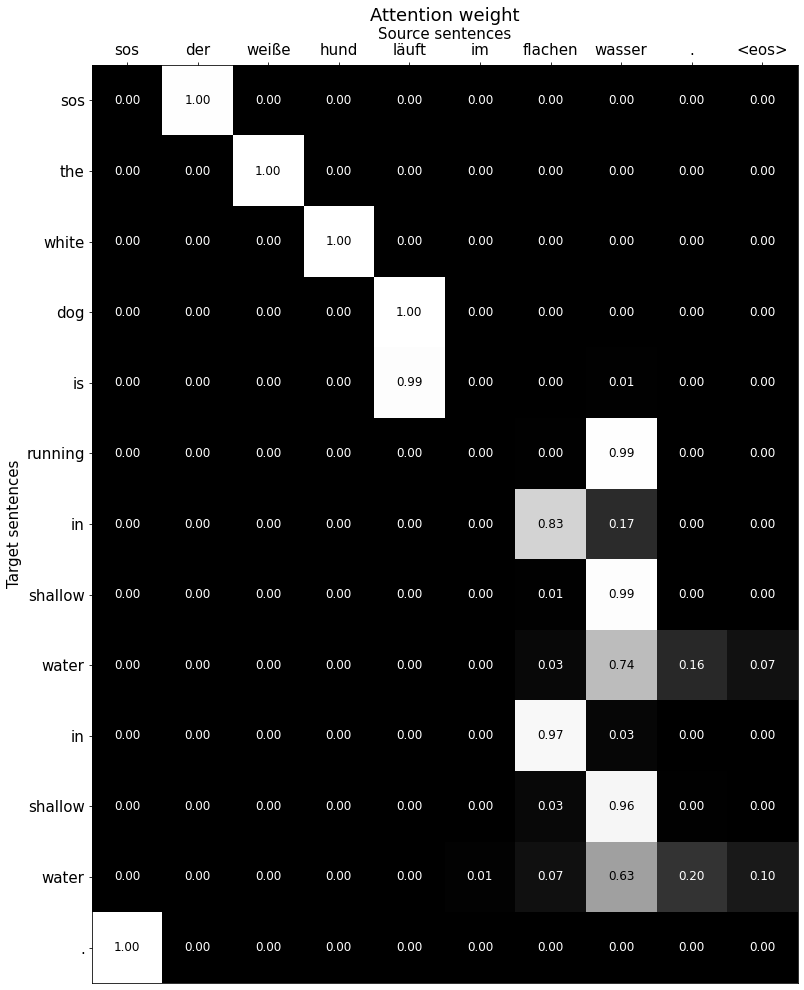

In [ ]:
#Translate test example
test_idx=random.choice(range(len(test_data)))
test_example=test_data.examples[test_idx]
test_src=test_example.src
test_trg=test_example.trg

#translated source sent
translated_trg,attn_w=translate_sents(s2s_model,test_src,SRC_de,TRG_en,100,device)
print(f'Source sentences:{test_src}\n')
print(f'Actual target sentence:{test_trg}\n')
print(f"model translated target sentence:{' '.join(translated_trg)}\n")

#get tick labels location
test_src=['sos']+test_src+['<eos>']
translated_trg=['sos']+translated_trg
#transform attention weight to numpy
attn_w=attn_w[0].cpu().clone().detach().numpy()
display_attnW(attn_w,test_src,translated_trg)

使用BLEU Metrics來去衡量模型的performance

In [ ]:
def compute_bleu_score(data,model,src_field,trg_field,device):
  predicts=[]
  labels=[]
  for i in range(len(data)):
    example=data[i]
    src=vars(example)['src']
    trg=vars(example)['trg']
    #model predict
    translated,_=translate_sents(model,src,src_field,trg_field,100,device)

    #add to predicts and labels
    predicts.append(translated)
    labels.append([trg])
  
  #compute bleu
  blue_score=metrics.bleu_score(predicts,labels,weights=[0.25,0.25,0.25],max_n=3)
  return blue_score

In [ ]:
test_bleuScore=compute_bleu_score(test_data,s2s_model,SRC_de,TRG_en,device)
print(f'BLEU score:{test_bleuScore}')

BLEU score:0.48691925406455994
